#### Instance Segmentation with Mask Region Based Convolutional Neural Network

In [1]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# default COCO objects
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def get_prediction(img_path, threshold, objects):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [objects[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3, objects=COCO_INSTANCE_CATEGORY_NAMES):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold, objects)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    #cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # no bounding boxes required
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  return img

* Obtain segmentation instance, apply style transfer to it (store as a mask), and superimpose that mask on top of the original image (excluding the background)

In [2]:
# Separating out the object names will be useful in object-specific filtering, but not instance segmentation
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

C:\Users\datta\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


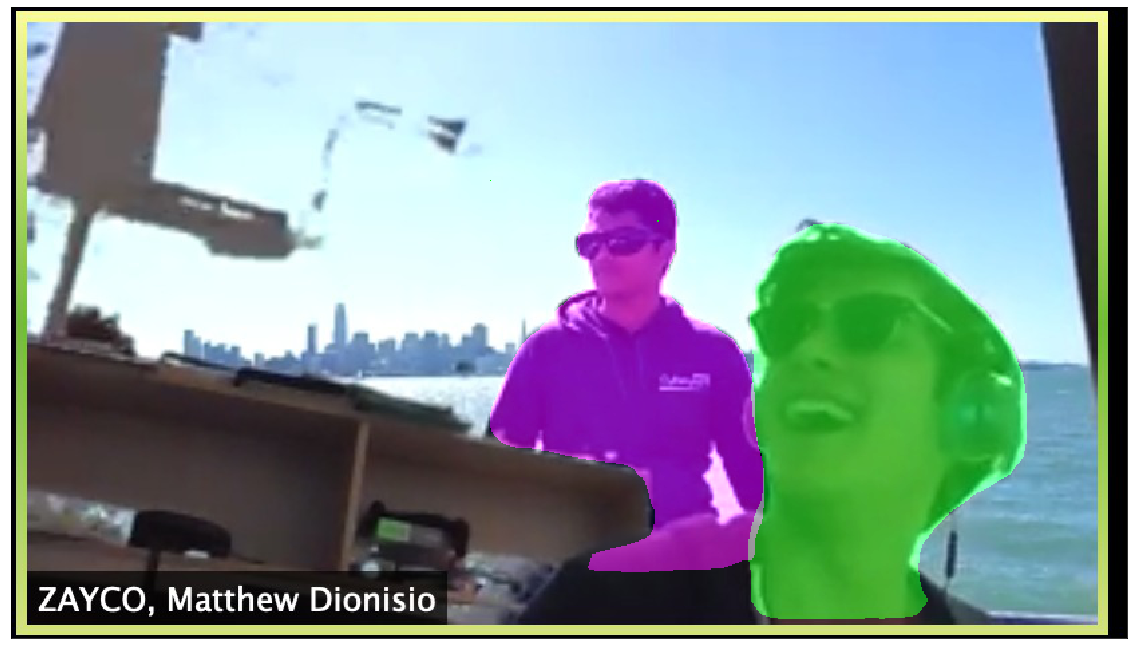

In [80]:
img = instance_segmentation_api(img_path='./payload/IMG-20200401-WA0002.jpg', threshold=0.75, rect_th=0, text_size=0, text_th=0, objects=COCO_INSTANCE_CATEGORY_NAMES)

In [82]:
import matplotlib
matplotlib.image.imsave('./payload/IMG-20200401-WA0002_MASKcolor.png', img)

In [87]:
# img_path='./payload/IMG-20200401-WA0002.jpg'
# img_path[:-4]+str("_MASK")+".png"

'./payload/IMG-20200401-WA0002_MASK.png'

In [3]:
img_original = Image.open('./payload/A09RRH/A09RRH.gif-0.png')
transform = T.Compose([T.ToTensor()])
img = transform(img_original)
pred = model([img])

C:\Users\datta\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


(334, 498)


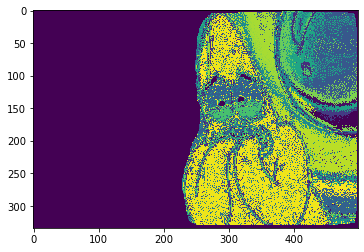

In [4]:
segment = 0
mask = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()[segment]

# print mask of image with the original image pixels
img_array = np.array(img[0])
# if False, set as 0 (black)
print(img_array.shape)
# img_array[img_array.shape[0]-1][img_array.shape[1]-1]

masked_img = []
for i in range(img_array.shape[0]):
    tmp=[]
    for j in range(img_array.shape[1]):
        if mask[i][j] == False:
            tmp.append(float(0))
        else:
            tmp.append(img_array[i][j])
    masked_img.append(tmp)
    
masked_img_array = np.array(masked_img)
plt.imshow(masked_img_array) # Export this mask image for style transfer
plt.show()

In [5]:
import matplotlib
matplotlib.image.imsave('./payload/IMG-20200401-WA0002_MASK.png', masked_img_array)

In [6]:
from faststyletransfer_eval import FasterStyleTransfer
FasterStyleTransfer("./fast_neural_style_transfer/models/mosaic_style__200_iter__vgg19_weights.pth", './payload/IMG-20200401-WA0002_MASK.png', './payload/IMG-20200401-WA0002_FST.png')


torch.Size([1, 3, 512, 763])


C:\Users\datta\OneDrive - HKUST Connect\GIFShop Wizard\github repo\faststyletransfer_eval.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_output = transformer(Variable(img_tensor, volatile=True))


In [8]:
# # combining two images on top of each other
# import numpy.ma as ma
# plt.imshow(combined_masks)
# plt.show()
# plt.imshow(img[2])
# plt.show()
# combined_masks = ma.masked_array(img[2], masked_img_array>0) # clears out pixels so that we can superimpose
# masked_img = cv2.addWeighted(np.array(combined_masks, np.float64), 0, np.array(masked_img_array, np.float64), 0.5, 0)
# plt.imshow(masked_img)
# plt.show()
# # split the image as 50% focus on masked_img_array, 50% on combined_masks
# masked_img = cv2.addWeighted(np.array(masked_img_array, np.float64), 0.5, np.array(combined_masks, np.float64), 0.5, 0)
# plt.imshow(masked_img)
# plt.show()

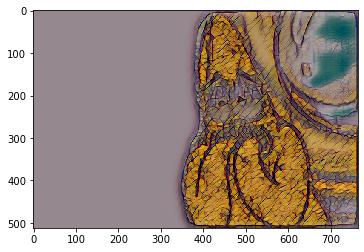

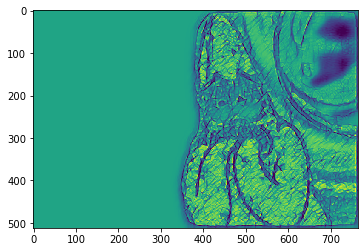

[0.58, 0.12, 0.31, 0.44, 0.68, 0.64, 0.24, 0.6, 0.42, 0.61, 0.51, 0.26, 0.11, 0.69, 0.27, 0.36, 0.28, 0.53, 0.78, 0.45, 0.87, 0.23, 0.03, 0.54, 0.21, 0.46, 0.63, 0.13, 0.72, 0.55, 0.81, 0.48, 0.73, 0.56, 0.57, 0.4, 0.82, 0.49, 0.41, 0.66]


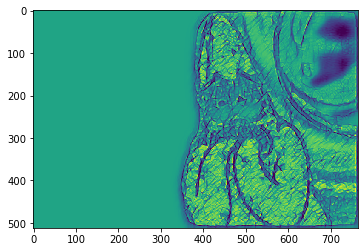

In [37]:
# combining two images on top of each other

style_img = Image.open('./payload/IMG-20200401-WA0002_FST.png')
plt.imshow(style_img)
plt.show()
style_img = style_img.convert('RGB')
transform = T.Compose([T.ToTensor()])
style_img = transform(style_img)
plt.imshow(style_img[0])
plt.show()


def clearBackgroundColour(style_img=style_img, style_img_index = 0, number_of_checks = 5, rejection_threshold1=2, rejection_threshold2=2):

    pix_value = []
    for i in range(number_of_checks):
        #pix_value.append(float(style_img[0][int(random.uniform(0,style_img.shape[1]))][int(random.uniform(0,style_img.shape[2]))]))
        val = float("{:.2f}".format(style_img[0][int(random.uniform(0,style_img.shape[1]))][int(random.uniform(0,style_img.shape[2]))]))
        pix_value.append(val)
        
    count_heuristic = list(set(pix_value))
    if len(count_heuristic) <= rejection_threshold1:
        for x in set(pix_value):
            if pix_value.count(x) > rejection_threshold2:
                pix_remove = x
    
    masked_img = []
    for i in range(style_img[style_img_index].shape[0]):
        tmp=[]
        for j in range(style_img[style_img_index].shape[1]):
            if float(style_img[style_img_index][i][j]) == float(pix_remove):
                tmp.append(float(0))
            else:
                tmp.append(style_img[style_img_index][i][j])
        masked_img.append(tmp)
        
    return np.array(masked_img), pix_remove

        
masked_img_array, pix_remove = clearBackgroundColour(style_img=style_img, style_img_index = 0, number_of_checks = 100, rejection_threshold1=50, rejection_threshold2=5)

# masked_img_array = np.array(masked_img)
plt.imshow(masked_img_array)
plt.show() # has some background around the sides, mostly because 0.540 and 0.535 are not exactly the same values

# import numpy.ma as ma
# combined_masks = ma.masked_array(img[2], style_img>0) # clears out pixels so that we can superimpose
# # split the image as 50% focus on masked_img_array, 50% on combined_masks
# masked_img = cv2.addWeighted(np.array(style_img[0], np.float64), 0.5, np.array(combined_masks, np.float64), 0.5, 0)
# plt.imshow(masked_img)
# plt.show()

In [39]:
masked_img_array

array([[0.58431375, 0.58431375, 0.58431375, ..., 0.5529412 , 0.54509807,
        0.5294118 ],
       [0.58431375, 0.58431375, 0.58431375, ..., 0.5529412 , 0.5529412 ,
        0.54901963],
       [0.58431375, 0.58431375, 0.58431375, ..., 0.53333336, 0.5372549 ,
        0.54901963],
       ...,
       [0.58431375, 0.58431375, 0.58431375, ..., 0.44705883, 0.44313726,
        0.44705883],
       [0.58431375, 0.58431375, 0.58431375, ..., 0.44313726, 0.4392157 ,
        0.44705883],
       [0.58431375, 0.58431375, 0.58431375, ..., 0.4392157 , 0.43529412,
        0.4392157 ]], dtype=float32)

In [41]:
# reshaping (Assuming style image will be larger than content image)
req_image = img[0]
masked_img_array_reshaped = masked_img_array[0:len(req_image)]

masked_img_array_reshaped_2 = []
for index in range(len(masked_img_array_reshaped)):
    masked_img_array_reshaped_2.append(masked_img_array_reshaped[index][0:len(req_image[0])])
masked_img_array_reshaped_2 = np.array(masked_img_array_reshaped_2)

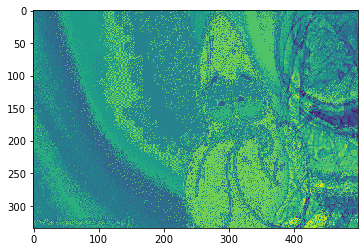

In [43]:
import numpy.ma as ma
combined_masks = ma.masked_array(img[0], masked_img_array_reshaped_2>0) # clears out pixels so that we can superimpose
# split the image as 50% focus on masked_img_array, 50% on combined_masks
masked_img = cv2.addWeighted(np.array(masked_img_array_reshaped_2, np.float64), 0.5, np.array(combined_masks, np.float64), 0.5, 0)
plt.imshow(masked_img)
plt.show()